In [3]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, pingouin as pin, matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines


import pylab
import ast

pd.set_option('precision', 2)
pd.options.display.float_format = '{:20.2f}'.format
%matplotlib inline

In [4]:
import cityImage as ci
import ABManalysis as af

## This notebook just generates figures as in the accompanying paper

## 0.1 Processing

In [13]:
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
palette = ['b', 'gold', 'mediumseagreen', 'tomato']
palette_light = ['aliceblue', 'lemonchiffon', 'honeydew', 'mistyrose']
labels = ['Angular change scenario','Region-based scenario',  'Barrier scenario', 'Region-Barrier scenario']
labels_short = ['AC scenario', 'RB scenario', 'BB scenario', 'RBB scenario']
cities =['London', 'Paris']
captions = ['a)', 'b)']
routes_gdfs_all = []
edges = []

In [14]:
## load routes

for city in cities:
    input_path = 'Input/regionBasedNavigation/'+city 
    output_path = 'Outputs/regionBasedNavigation/'+city 
    edges_tmp = gpd.read_file(output_path+'_pedSim_RB.shp', use_unicode=True, driver='ESRI Shapefile')
    edges.append(edges_tmp)
    routes_gdfs = []
    
    for n, model in enumerate(route_choice_models):
        routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
        routes_gdf['districts'] = [ast.literal_eval(i) for i in routes_gdf['ds_str']]
        routes_gdfs.append(routes_gdf)
    
    routes_gdfs_all.append(routes_gdfs)

## Figures section 4.1

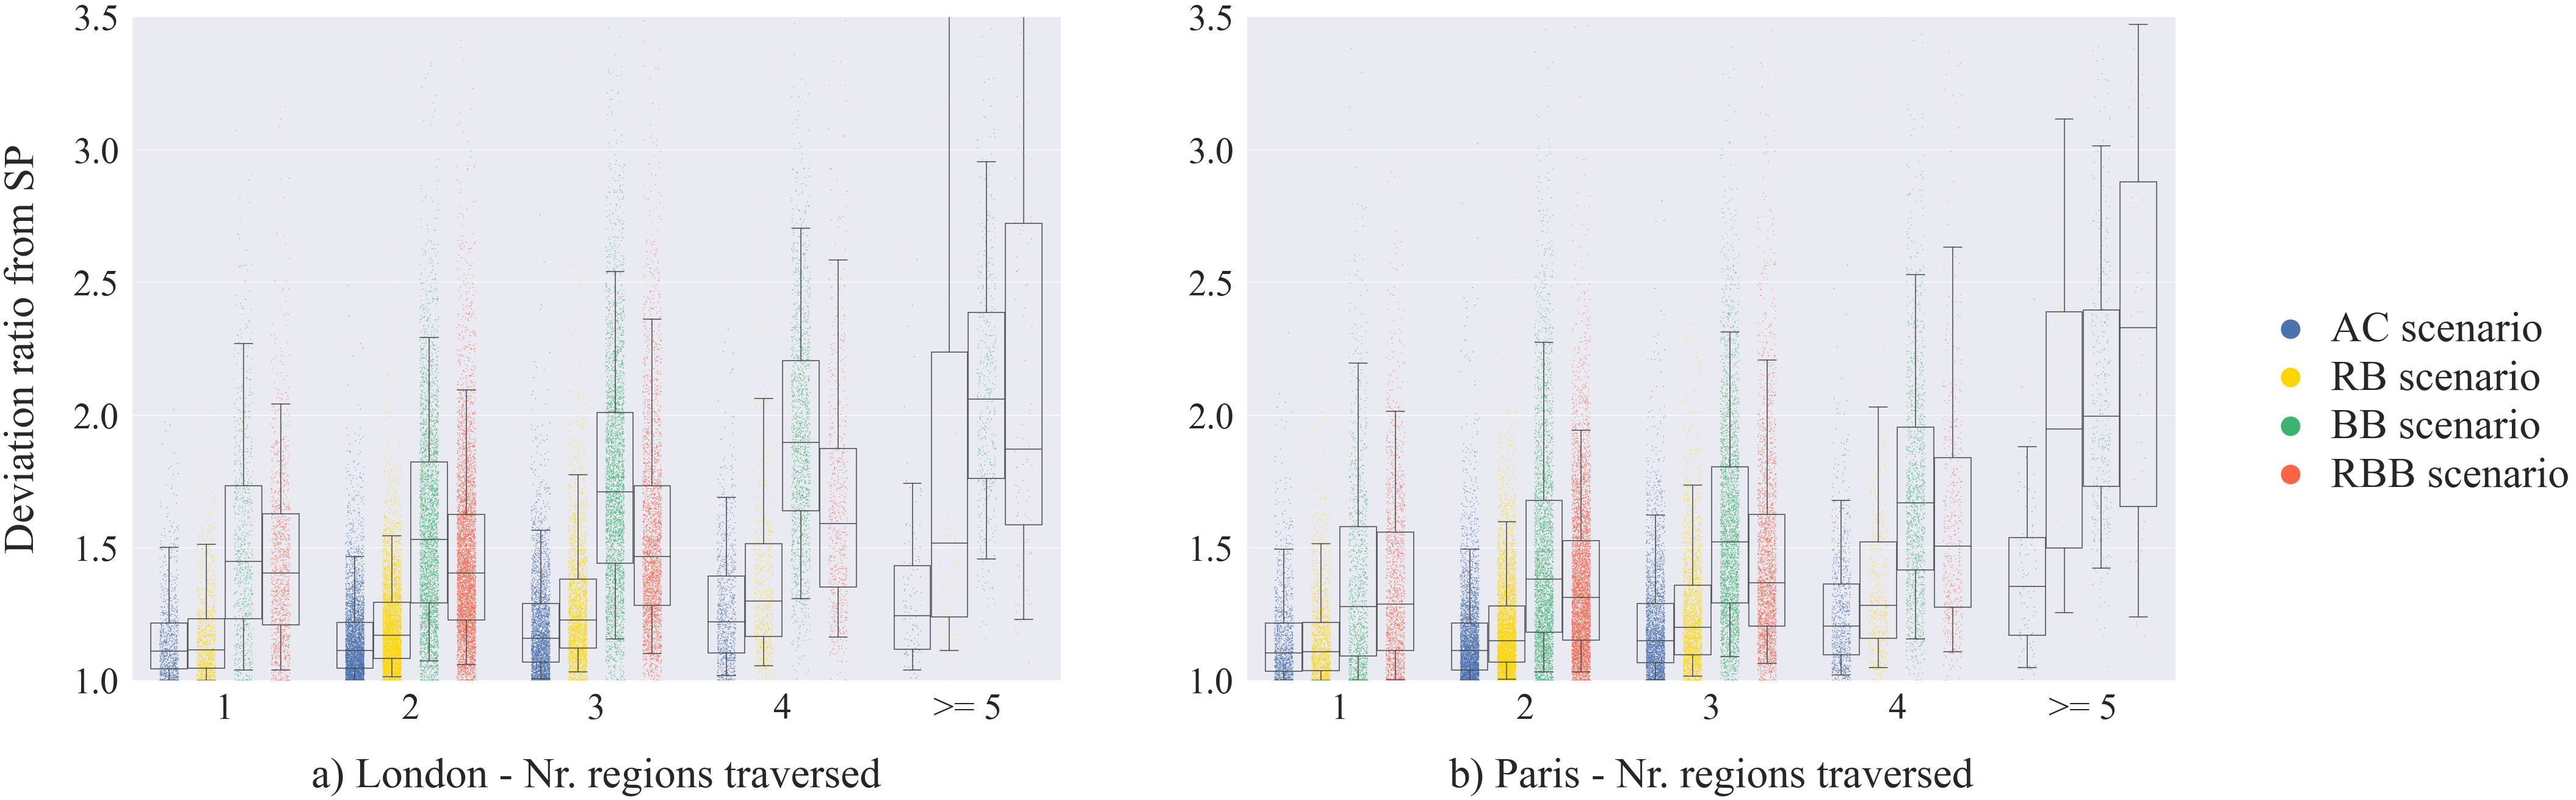

In [29]:
from matplotlib import text

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(60,20))

for n, ax in enumerate(axes):
    routes_gdfs = routes_gdfs_all[n]
    
    for nn, model in enumerate(route_choice_models):
        routes_gdfs[nn]['route_choice_models'] = model
    
    merged = pd.concat(routes_gdfs) 
    merged['nr_dis'] = np.where(merged['nr_dis']<=5, merged['nr_dis'], 5)
    
    ## nr district vs deviation from shortest path
    sns.stripplot(ax = ax, x="nr_dis", y="sp_dev", hue = 'route_choice_models', data=merged,  palette = palette, size=3, 
                  marker=".", edgecolor="none", jitter = 0.20, dodge = True, alpha=0.85, zorder = 0)
    sns.set()
    sns.set_color_codes()
    handles,_ = ax.get_legend_handles_labels()
    sns.boxplot(ax = ax, x='nr_dis', y='sp_dev', hue = 'route_choice_models', data= merged, 
                palette = palette, whis = [5,95], showfliers = False, boxprops=dict(alpha=1), zorder = 1)
    
    count = 0 
    for nn, box in enumerate(ax.artists):
        box.set_facecolor('None')
        count +=1
        if count > 3: 
            count = 0
    
    sns.set()
    sns.set_color_codes()
    ax.tick_params(axis='both', which='major', labelsize= 60, pad = 15)
    
    ax.set_xlabel(captions[n]+" "+cities[n]+ " - Nr. regions traversed", fontsize = 70, fontfamily = 'Times New Roman', 
                  labelpad = 50)
    
    ax.yaxis.grid(True)
    if n == 0:
        ax.set_ylabel('Deviation ratio from SP', fontsize = 70, fontfamily = 'Times New Roman', labelpad = 50)
    else: 
        ax.set_ylabel('', fontsize = 55, fontfamily = 'Times New Roman', labelpad = 30)     
        
    ax.set_ylim(1.0, 3.5)
    ax.set_yticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    for tick in ax.get_yticklabels(): 
        tick.set_fontname('Times New Roman')
    
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    xlabels[-1] = '>= 5'
    ax.set_xticklabels(xlabels)
    for tick in ax.get_xticklabels(): 
        tick.set_fontname('Times New Roman')
    ax.get_legend().remove()

legend = plt.legend(handles, labels_short, markerscale= 4, handletextpad= 5, labelspacing=1.5, frameon = False)
legend.get_frame().set_facecolor('none')

plt.setp(legend.get_texts(), fontsize='70', va='center', fontfamily = 'Times New Roman') # for legend text
legend.set_bbox_to_anchor((1.10, 0.25, 0.33, 0.33))

In [ ]:
fig.savefig("Outputs/Figures/regionBasedNavigation/Fig5.pdf", bbox_inches='tight')

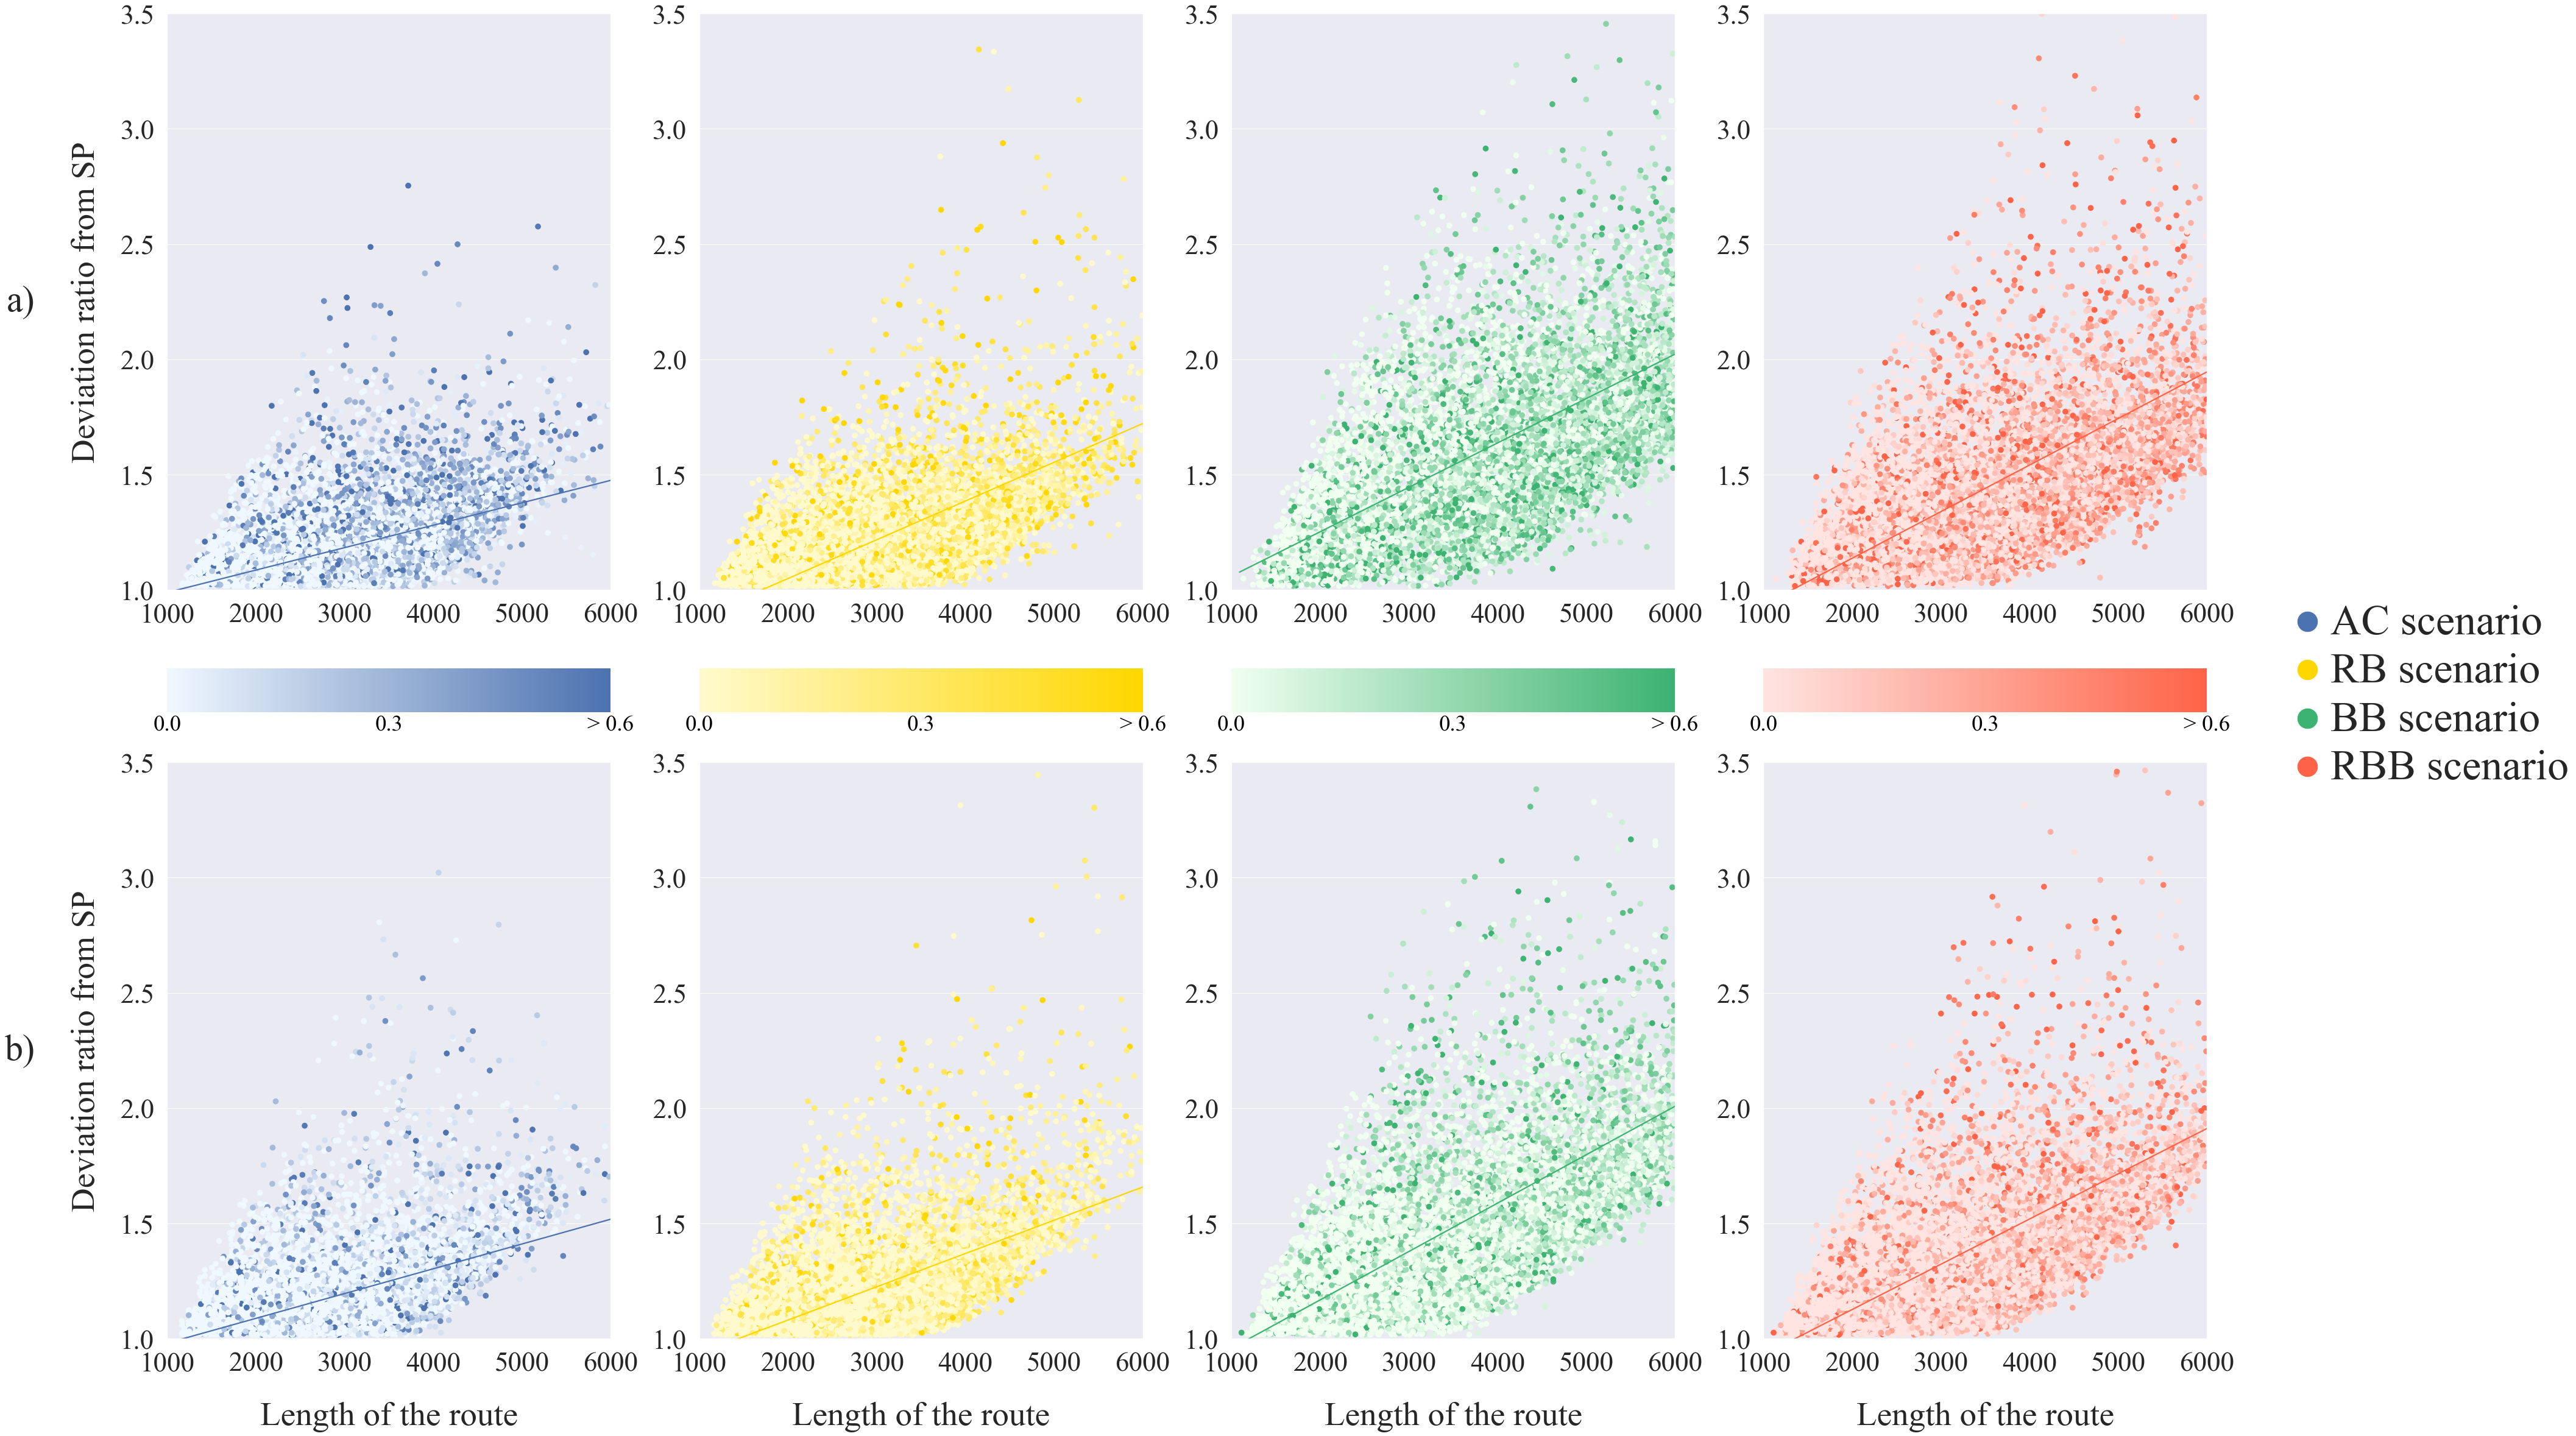

In [43]:
handles = []
fig, rows = plt.subplots(nrows = 2, ncols = 4, figsize=(60,40))
plt.subplots_adjust(hspace=0.3)

for n,city in enumerate(cities):
    axes = rows[n]
    routes_gdfs = routes_gdfs_all[n]
   
    for nn, model in enumerate(route_choice_models):            
        routes_gdf = routes_gdfs[nn].copy()
        routes_gdf['length'] = routes_gdf.geometry.length
    
        cmap =  ci.cmap_two_colors(palette_light[nn],palette[nn])
        norm = mpl.colors.Normalize(vmin=0, vmax= 0.60)
        
        # to avoid too high density of points
        data = routes_gdf[routes_gdf.length <= 6000].copy()
        data = data[data.sp_dev > 1.015].copy()
        
        axes[nn].scatter(x= 'length', y = 'sp_dev', c = 'bar', data = data, s=75, cmap=cmap, norm = norm)
        sns.set()
        sns.set_color_codes()

        sns.regplot(ax = axes[nn],x= 'length', y = 'sp_dev', data=routes_gdf, ci = None, scatter=False, color= palette[nn])
        
        axes[nn].tick_params(axis='both', which='major', labelsize= 45, pad = 15)
        if n!= 0: 
            axes[nn].set_xlabel("Length of the route", fontsize = 55, fontfamily = 'Times New Roman', labelpad = 40)
        else:
            axes[nn].set_xlabel(" ", fontsize = 55, fontfamily = 'Times New Roman', labelpad = 40)
         
        axes[nn].xaxis.grid(False)
        axes[nn].yaxis.grid(True)
        if nn == 0:
            axes[nn].set_ylabel('Deviation ratio from SP',  fontsize = 55, fontfamily = 'Times New Roman', labelpad = 30)
            axes[nn].annotate(captions[n], xy=(0, 0.5), xytext=(-axes[nn].yaxis.labelpad-30,0), xycoords=axes[nn].yaxis.label, 
                            textcoords='offset points', fontsize = 60, ha='right', va='center', fontfamily = 'Times New Roman')
            
        else: axes[nn].set_ylabel('',  fontsize = 55, fontfamily = 'Times New Roman', labelpad = 30)

        axes[nn].set_xlim(1000, 6000)
        axes[nn].set_ylim(1.0, 3.5)
        axes[nn].set_xticks([1000, 2000, 3000, 4000, 5000, 6000])
        axes[nn].set_yticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5])

        for tick in axes[nn].get_yticklabels(): tick.set_fontname('Times New Roman')
        for tick in axes[nn].get_xticklabels(): tick.set_fontname('Times New Roman')
        handles.append(mlines.Line2D([], [], color=palette[nn], marker='.', linestyle='None', markersize=13))
        
        if n == 0:
             af.generate_ax_hcolorbar(cmap, fig, axes[nn], len(cities), len(route_choice_models), 'black', 55, norm = norm, ticks = 2, symbol = 
                                       True)
        
    if n == 1:
        legend = plt.legend(handles, labels_short, markerscale= 5, handletextpad= 2.5, labelspacing=1.5, frameon = False)
        legend.get_frame().set_facecolor('none')
        plt.setp(legend.get_texts(), fontsize='70', va='center', fontfamily = 'Times New Roman') # for legend text
        legend.set_bbox_to_anchor((1.50, 2.50, 0.33, 0.33))

In [30]:
fig.savefig("Outputs/Figures/regionBasedNavigation/Fig6.pdf", bbox_inches='tight')

## Figure section 4.2 - Significance test on road types portions
* Meters traversed along pedestrian roads
* Meters traversed along major roads
* Meters traversed along barriers

In [26]:
columns = ['ped', 'maj', 'bar'] 
titles = ['Pedestrian Roads', 'Major Roads', 'Natural Barriers']
routes_stats_London = af.generate_routes_stats(routes_gdfs_all[0], route_choice_models, columns, titles)    
routes_stats_Paris = af.generate_routes_stats(routes_gdfs_all[1], route_choice_models, columns, titles)

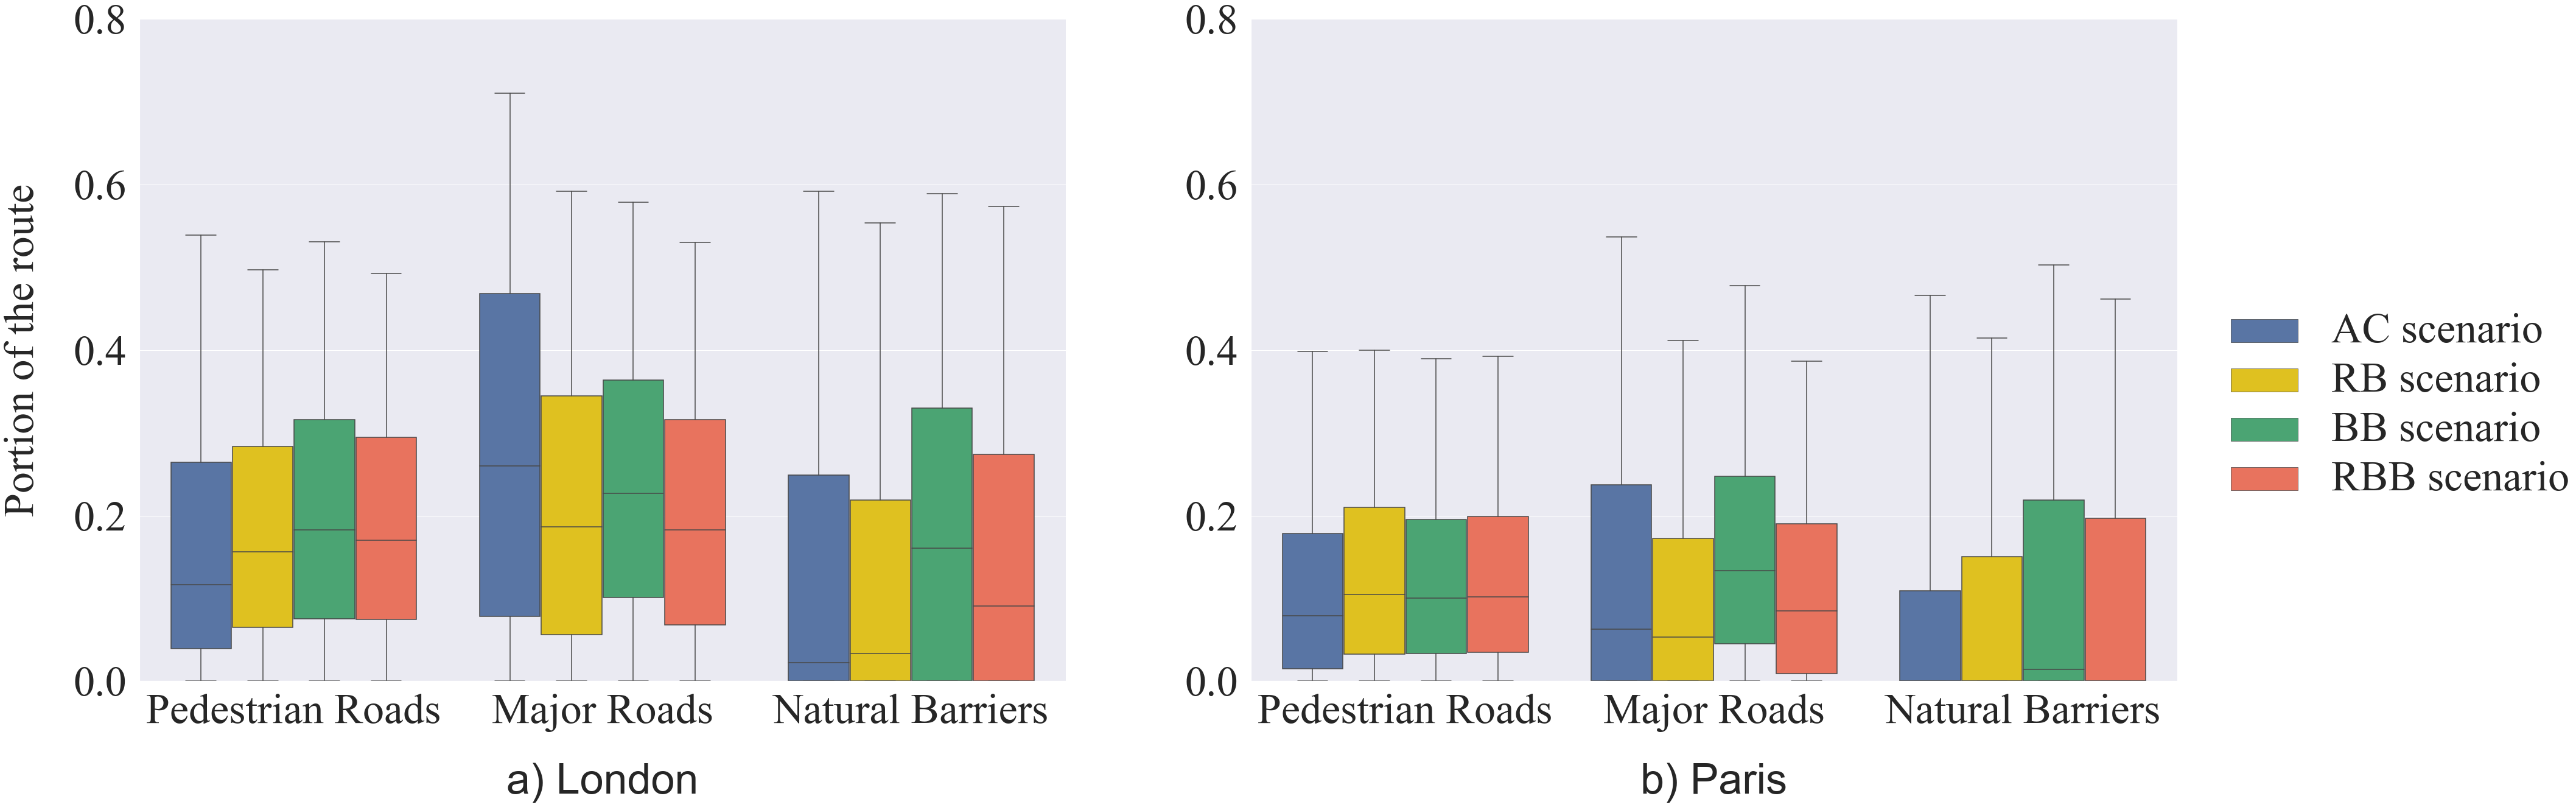

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(60,20))
routes_stats = [routes_stats_London, routes_stats_Paris]

for n, ax in enumerate(axes):
    sns.boxplot(ax = ax, x='type', y='values', hue = 'routeChoice', data= routes_stats[n], 
                palette = palette, whis = [5,95], showfliers = False)
    sns.set()
    sns.set_color_codes()
    
    ax.tick_params(axis='both', which='major', labelsize= 70, pad = 15)
    ax.set_xlabel(captions[n]+" "+cities[n], fontsize = 70, labelpad = 50)
    
    if n == 0: ax.set_ylabel('Portion of the route', fontsize = 70, fontfamily = 'Times New Roman', labelpad = 50)
    else: ax.set_ylabel('', fontsize = 20, fontfamily = 'Times New Roman', labelpad = 30)
    plt.rcParams['font.family'] = 'Times New Roman'

    for tick in ax.get_yticklabels(): tick.set_fontname('Times New Roman')
    for tick in ax.get_xticklabels(): tick.set_fontname('Times New Roman')
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0.0, 0.8)
    ax.yaxis.grid(True)
    
handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles, labels_short, markerscale= 110, handletextpad= 5, labelspacing=1.5, frameon = False,
                    handlelength = 10, handleheight = 5)
legend.get_frame().set_facecolor('none')

plt.setp(legend.get_texts(), fontsize='70', va='center', fontfamily = 'Times New Roman') # for legend text
legend.set_bbox_to_anchor((1.10, 0.25, 0.33, 0.33))

In [671]:
fig.savefig("Outputs/Figures/regionBasedNavigation/Fig9.pdf", bbox_inches='tight')